# Batched deskewing 

I'm sorry but somehow I lost the notebook I'd done all the workup on

This one takes a czi into dask, batches the deskew



In [1]:
import dask
import dask.array as da
from pyclesperanto_prototype import imshow

import pyclesperanto_prototype as cle

from aicsimageio import AICSImage
from functools import partial
import numpy as np


In [2]:
voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3
deskewing_angle_in_degrees = 30

In [3]:
data_path = '../data/RAPA_treated-01_resaved_c02_t_100.czi'
data = AICSImage(data_path)

In [4]:
image = data.dask_data
image

,Array,Chunk
Bytes,19.44 GiB,199.07 MiB
Shape,"(100, 1, 501, 140, 1488)","(1, 1, 501, 140, 1488)"
Count,500 Tasks,100 Chunks
Type,uint16,numpy.ndarray


Looks like it already chunks in time by default - that's handy

In [5]:
def recursive_imageProcess(im,func,*args,**kwargs):
    if len(im.shape) > 3:
        output = []
        for sl in im:
            output.append(recursive_imageProcess(sl,func,*args,**kwargs))
        return da.asarray(output)          
    return func(im,*args,**kwargs)

In [6]:
deskew = partial(cle.deskew_y,angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)

In [7]:
%%time
output = recursive_imageProcess(image,deskew)

CPU times: user 1min 27s, sys: 50.1 s, total: 2min 17s
Wall time: 1min 33s


In [8]:
output


,Array,Chunk
Bytes,45.09 GiB,76.95 MiB
Shape,"(100, 1, 70, 1162, 1488)","(1, 1, 70, 581, 496)"
Count,1200 Tasks,600 Chunks
Type,float32,numpy.ndarray


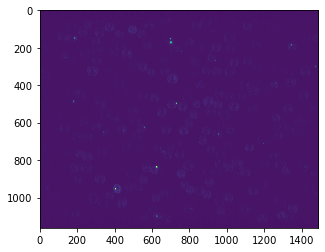

In [9]:
imshow(output[5,0])

For the sake of completeness, let's try chunking in Y. 

In [10]:
#assign this dynamically based on GPU? 
nChunks = 4

tiles = da.rechunk(image,(1,-1,-1,-1,image.shape[4]/4))
tiles


,Array,Chunk
Bytes,19.44 GiB,49.77 MiB
Shape,"(100, 1, 501, 140, 1488)","(1, 1, 501, 140, 372)"
Count,1300 Tasks,400 Chunks
Type,uint16,numpy.ndarray


In [11]:
deskew_for_chunks = partial(recursive_imageProcess,func=deskew)
tile_map = da.map_blocks(deskew_for_chunks,tiles,dtype='uint16')

In [12]:
%%time
output = tile_map.compute()
output.shape

CPU times: user 2min 4s, sys: 1min 22s, total: 3min 26s
Wall time: 38.2 s


(100, 1, 70, 1162, 1488)

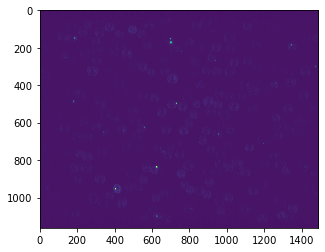

In [13]:
imshow(output[5,0])